In [893]:
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

#### Параметры СМО

In [1119]:
λ = 3.55
μ = 1.5
p = 0.8
q = 1 - p

m = 10
n = 3

Разыгрываем событие отказа в обслуживании

In [1060]:
def play_probability(p):
    rnd = np.random.uniform()
    return rnd <= p

#### Запрос

Содержит иформацию о времени, проведенном в системе и в очереди

In [1061]:
class Request:
    ID = 0
    
    def __init__(self, cur_time):
        self.id = Request.ID
        Request.ID += 1
        
        self.time_in_queue = 0
        self.time_in_system = 0
        
        self.start_in_queue = cur_time
        self.start_in_system = cur_time
    
    def enqueue(self, cur_time):
        self.start_in_queue = cur_time
        #print('Reuqest #{} Enqueue: {}'.format(self.id, cur_time))
    
    def dequeue(self, cur_time):
        self.time_in_queue += cur_time - self.start_in_queue
        #print('Reuqest #{} Dequeue: {}'.format(self.id, cur_time))
    
    def out(self, cur_time):
        self.time_in_system += cur_time - self.start_in_system
    
    def __str__(self):
        return 'Request #{} In queue: {}, in system: {}'.format(self.id, self.time_in_queue, self.time_in_system)

#### Канал исполнения

In [1062]:
class Channel:
    ID = 0
    def __init__(self, μ, reject_probability, on_reject):
        self.reject_probability = reject_probability
        self.on_reject = on_reject
        self.μ = μ
        
        self.free = True
        self.end_at = 0
        self.request = None
        
        self.id = Channel.ID
        
        Channel.ID += 1
    
    def run(self, start_at, request):
        self.free = False
        self.end_at = start_at + np.random.exponential(1 / self.μ)
        self.request = request
        
        #print('[Started] Channel #{}: {:.4} -> {:.4}'.format(self.id, start_at, self.end_at))
    
    def try_free(self, cur_time):
        if not self.free and self.end_at < cur_time:
            self.free = True
            
            rejected = play_probability(self.reject_probability)
            if rejected:
                self.on_reject(self.request)
                self.run(cur_time, self.request)
                #print('[Rejected] Channel #{}: free at {:.4}'.format(self.id, cur_time))
            else:
                #print('[Completed] Channel #{}: free at {:.4}'.format(self.id, cur_time))
                return self.request

In [1284]:
class SMOStats:
    def __init__(self, smo):
        self.smo = smo
        
        self.queue_sizes = []
        self.working_channels = []
        self.total_requests = []
        self.requests = []
        self.request_queue_times = []
        self.request_times = []
        
        self.work_intervals = []
        self.process_intervals = []
        
        self.rejections = 0
        self.cancellations = 0
        
    def collect(self):
        cur_working_channels = 0
        for channel in self.smo.channels:
            cur_working_channels += not channel.free
            
        cur_queue_size = len(self.smo.queue)
            
        self.queue_sizes.append(cur_queue_size)
        self.working_channels.append(cur_working_channels)
        self.total_requests.append(cur_queue_size + cur_working_channels)
    
    def cancel(self):
        self.cancellations += 1
    
    def reject(self):
        self.rejections += 1
        
    def add_work(self, interval):
        self.work_intervals.append(interval)
    
    def add_process(self):
        self.process_intervals.append(self)
    
    def out(self, request):
        self.requests.append(request)
        self.request_queue_times.append(request.time_in_queue)
        self.request_times.append(request.time_in_system)
    
    def build(self):
        d = {'Размер очереди': self.queue_sizes, 
             'Занятые каналы': self.working_channels,
             'Заявки в системе': self.total_requests}
        
        d1 = {'Время запроса в очереди': self.request_queue_times,
              'Время запроса в системе': self.request_times}
        
        return pd.DataFrame(data=d), pd.DataFrame(data=d1)
    
    def get_cancel_prob(self):
        return self.cancellations / self.smo.request_limit
    
    def get_states_probs(self):
        states = [0] #система пуста
        states += list(range(1, self.smo.n + 1)) #работают каналы
        states += list(range(self.smo.n + 1, self.smo.n + self.smo.m + 1)) #работают каналы и занята очередь
        
        state_counts = np.zeros(len(states))
        
        for req in self.total_requests:
            state_counts[req] += 1
        
        return states, state_counts

In [1159]:
class SMO:
    def __init__(self, n, m, λ, μ, p, tick_size, request_limit):
        self.n = n
        self.m = m
        self.λ = λ
        self.μ = μ
        self.p = p
        self.q = 1 - p
        self.tick_size = tick_size
        self.request_limit = request_limit
        
        self.reset(n, λ)
    
    def reset(self, n, λ):
        Channel.ID = 1
        Request.ID = 1
        
        self.stats = SMOStats(self)
        self.request = 0
        self.channels = [Channel(self.μ, self.q, self.request_rejected) for _ in range(n)]
        self.queue = []
        self.cur_time = 0.
        self.next_time = np.random.exponential(λ)
    
    def request_rejected(self, request):
        self.stats.reject()
    
    def push(self, request=None):
        if not request:
            self.request += 1
            request = Request(self.cur_time)
            
        if len(self.queue) < self.m:
            request.enqueue(self.cur_time)
            self.queue.append(request)
        else:
            self.stats.cancel()
            #print('Canceled', request)
        

    def free_channels(self):
        for channel in self.channels:
            request = channel.try_free(self.cur_time)
            if request:
                request.out(self.cur_time)
                self.stats.out(request)

    def dequeue_requests(self):
        for channel in self.channels:
            if len(self.queue) == 0:
                break
            
            if channel.free:
                request = self.queue.pop(0)
                request.dequeue(self.cur_time)
                channel.run(self.cur_time, request)
    
    def free_all(self):
        while not self.is_all_free():
            self.tick()
    
    def is_all_free(self):
        for channel in self.channels:
            if not channel.free: return False

        return True
    
    def tick(self):
        self.free_channels()
        self.dequeue_requests()
        self.stats.collect()

        self.cur_time += self.tick_size
    
    def run(self):
        while self.request < self.request_limit:
            if self.cur_time >= self.next_time:
                self.next_time = self.cur_time + np.random.exponential(1 / λ)
                self.push()
                
                #print('Cur time: {:.4}, Next task arrives at {:.4}'.format(self.cur_time, self.next_time))

            self.tick()
        
        self.free_all()

In [1242]:
smo = SMO(n, m, λ, μ, p, 0.01, 10000)

print('Cur time: {:.4}, Next task arrives at {:.4}'.format(smo.cur_time, smo.next_time))

smo.run()

Cur time: 0.0, Next task arrives at 0.5951


In [1243]:
df_c, df_times = smo.stats.build()

In [1244]:
df_c.describe().T

,count,mean,std,min,25%,50%,75%,max
Размер очереди,283147.0,3.857336,3.305691,0.0,0.0,3.0,7.0,10.0
Занятые каналы,283147.0,2.728561,0.661360,0.0,3.0,3.0,3.0,3.0
Заявки в системе,283147.0,6.585897,3.668658,0.0,3.0,6.0,10.0,13.0


In [1245]:
df_times.describe().T

,count,mean,std,min,25%,50%,75%,max
Время запроса в очереди,9424.0,1.158948,1.030973,0.00,0.2200,1.0,1.81,6.41
Время запроса в системе,9424.0,1.978753,1.299759,0.01,0.9875,1.8,2.74,9.24


In [1246]:
print('Rejections:', smo.stats.rejections)
print('Cancelations:', smo.stats.cancellations)
print('Accepted:', len(smo.stats.requests))

Rejections: 2287
Cancelations: 576
Accepted: 9424


In [1247]:
cancel_prob = smo.stats.get_cancel_prob()

print('Вероятность отказа:', cancel_prob)

Вероятность отказа: 0.0576


In [1248]:
relative_bandwidth = 1 - cancel_prob

print('Относительная пропускная способность:', relative_bandwidth)

Относительная пропускная способность: 0.9424


In [1249]:
absolute_bandwidth = relative_bandwidth * λ

print('Абсолютная пропускная способность:', absolute_bandwidth)

Абсолютная пропускная способность: 3.34552


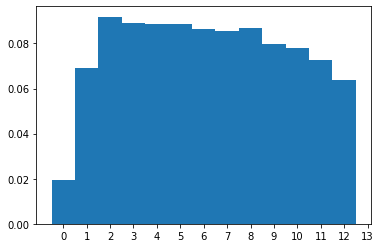

In [1250]:
states_bins, states_counts = smo.stats.get_states_probs()

plt.xticks(staes_bins)
plt.hist(smo.stats.total_requests, bins=np.array(staes_bins)-0.5, density=True);

In [1251]:
def get_rho(λ, n, m):
    return λ / (μ * p)


def get_free_probability(ρ, n, m):
    p0 = 1
    
    for k in range(1, n + 1):
        p0 += ρ**k / math.factorial(k)
    
    p0 += ρ**(n + 1) * (1 - (ρ / n)**m) / (n * math.factorial(n) * (1 - ρ / n))
    
    return 1 / p0


def get_state_probs(λ, μ, p, n, m):
    ρ = get_rho(λ, n, m)
    
    p0 = get_free_probability(ρ, n, m)
    probs = [p0]
    
    for k in range(1, n + 1):
        probs.append(ρ**k / math.factorial(k) * p0)
    
    for k in range(1, m + 1):
        probs.append(ρ**(n + k) / ( n**k * math.factorial(n)) * p0)
    
    return probs

In [1252]:
theor_probs = get_state_probs(λ, μ, p, n, m)
emp_probs = states_counts / sum(states_counts)

In [1253]:
pd.DataFrame(data={'Теоретическая вероятность': theor_probs, 'Практическая вероятность': emp_probs}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Теоретическая вероятность,0.018998,0.056202,0.083132,0.081977,0.080839,0.079716,0.078609,0.077517,0.076441,0.075379,0.074332,0.073300,0.072281,0.071278
Практическая вероятность,0.018259,0.065040,0.086580,0.083974,0.083723,0.083667,0.081516,0.080460,0.081975,0.075240,0.073375,0.068417,0.060114,0.057659


In [1255]:
def get_cancel_prob(ρ, n, m):
    p0 = get_free_probability(ρ, n, m)
    return ρ**(n + m)  / (n**m * math.factorial(n)) * p0

In [1256]:
theor_cancel_prob = get_cancel_prob(get_rho(λ, n, m), n, m)
theor_relative_bandwidth = 1 - theor_cancel_prob
theor_absolute_bandwidth = λ * theor_relative_bandwidth

In [1257]:
print('Теоретическая вероятность отказа:', theor_cancel_prob)
print('Практическая вероятность отказа:', cancel_prob)

Теоретическая вероятность отказа: 0.07127755574368404
Практическая вероятность отказа: 0.0576


In [1258]:
print('Теоретическая относительная пропускная способность:', theor_relative_bandwidth)
print('Практическая относительная пропускная способность:', relative_bandwidth)

Теоретическая относительная пропускная способность: 0.928722444256316
Практическая относительная пропускная способность: 0.9424


In [1259]:
print('Теоретическая абсолютная пропускная способность:', theor_absolute_bandwidth)
print('Практическая абсолютная пропускная способность:', absolute_bandwidth)

Теоретическая абсолютная пропускная способность: 3.2969646771099215
Практическая абсолютная пропускная способность: 3.34552


$$L_{och} = \frac{p_0\rho^{n+1}}{nn!}\sum_{k=1}^{m}k(\frac{\rho}{n})^{k-1}$$

In [1272]:
def get_theor_interval_len(ρ, n, m):
    p0 = get_free_probability(ρ, n, m)
    return p0 * ρ**(n + 1) / (n * math.factorial(n)) * sum(k * (ρ / n)**(k - 1) for k in range(1, m + 1))

In [1277]:
theor_queue_size = get_theor_interval_len(get_rho(λ, n, m), n, m)
pract_queue_size = np.mean(smo.stats.queue_sizes)

In [1278]:
print('Теоретическая длина очереди:', theor_queue_size)
print('Практическая длина очереди:', pract_queue_size)

Теоретическая длина очереди: 4.090669962582558
Практическая длина очереди: 3.8573355889343697


In [1275]:
theor_channel_loaded = get_rho(λ, n, m) * theor_relative_bandwidth
pract_channel_loaded = np.mean(smo.stats.working_channels)

In [1276]:
print('Теоретическое количество занятых каналов:', theor_channel_loaded)
print('Практическое количество занятых каналов:', pract_channel_loaded)

Теоретическое количество занятых каналов: 2.7474705642582675
Практическое количество занятых каналов: 2.7285614892617613


In [1279]:
theor_system_load = theor_queue_size + theor_channel_loaded
pract_system_load = np.mean(smo.stats.total_requests)

In [1280]:
print('Теоретическое количество заявок в системе:', theor_system_load)
print('Практическое количество заявок в системе:', pract_system_load)

Теоретическое количество заявок в системе: 6.838140526840825
Практическое количество заявок в системе: 6.5858970781961315
